# Advanced Lane Detection

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage import morphology
from collections import deque
%matplotlib inline

# Display intermediate steps for image processing and lane finding
showMe = 0


def display(img, title, color=1):
    '''
    display images
    img: rgb or grayscale
    title: figure title
    color: show image in color(1) or grasycale(0)
    '''
    if color:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Calibration Camera

In [2]:
def camera_calibration(folder, nx, ny, showMe=0):
    '''
    find (x, y) locations of all corners using openCV findChessBoardCorners
    folder: directory of the calibration images
    nx: expected number of corners along the x direction
    ny: expected number of corners along the y direction
    return a dictionary:
        ret: RMS Error of the calibration
        mtx: the camera matrix
        dist: distorsion coefficients
        rvecs: rotation vectors
        tvecs: translation vectors
    '''
    # Store object points and image points from all the images
    objpoints = [] #3D points in real world space
    imgpoints = [] #2D points in image plane
    #Prepare object points, like (0,0,0), (1, 0,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x, y coordinate
        
    assert len(folder) != 0, 'No file found in folder'
        
    for fname in folder:
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        img_sz = gray.shape[::-1]
            
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
            if showMe:
                draw_corners = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                display(draw_corners, 'Found all corners: {} '.format(ret))

    if len(objpoints) == len(imgpoints) and len(objpoints) != 0:
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_sz, None, None)
        return {'ret': ret, 'cameraMatrix': mtx, 'distorsionCoeff': dist, \
                    'rotationVec': rvecs, 'translationVec': tvecs}
    else:
        raise Error('Camera Calibration failed')


    
def correction(image, calib_params, showMe=0):
    '''
    Distorsion correction
    calib_params: calibration parameters returned by camera_calibration()
    '''
    corrected = cv2.undistort(image, calib_params['cameraMatrix'], calib_params['distorsionCoeff'], None, 
                         calib_params['cameraMatrix'])
    if showMe:
        display(image, 'Original', color=1)
        display(corrected, 'After correction', color=1)

        

nx = 9 #number of corners in a row
ny = 6 #numbers or corners in a column
folder_calibration = glob.glob("camera_cal/calibration*.jpg") #list of chessboard image files
calib_params = camera_calibration(folder_calibration, nx, ny, showMe=0)
# for a good calibration ret must be between 0.1 and 1.0
print('RMS Error of Camera calibration: {:.3f}'.format(calib_params['ret']) )
print('This number must be between 0.1 and 1.0')

RMS Error of Camera calibration: 1.030
This number must be between 0.1 and 1.0


# Image Processing

In [3]:
class ImageProcess():
    '''
    Processing methods of original images
    '''
    def __init__(self):
        pass
    
    def gaussianBlur(self, img, k_sz=5):
        # Useful to remove salt'n pepper noise - NOT USE HERE
        img = cv2.GaussianBlur(img, (k_sz, k_sz), 0)
        return img
    
    
    def directional_gradient(self, img, direction='x', thresh=[0, 255]):
        '''
        Gradient along vertical or horizontal direction using OpenCV Sobel 
        img: Grayscale
        direction: x(horizontal) or y(vertical) for gradient direction
        thresh: apply threshold on pixel intensity of gradient image
        output is a binary image
        '''
        if direction == 'x':
            sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
        elif direction == 'y':
            sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        
        sobel_abs = np.absolute(sobel)  #absolute value
        scaled_sobel = np.uint8(sobel_abs * 255/np.max(sobel_abs)) #turn sobel to 8bit image 0-255 intensity range
        binary_output = np.zeros_like(sobel)
        binary_output[(scaled_sobel>= thresh[0]) & (scaled_sobel <= thresh[1]) ] = 1 #generate binary
        
        return binary_output


    def mag_gradient(self, img, thresh=[0, 255]):
        '''
        Magnitude of gradient : sqrt(gradx**2 + grady**2)
        img: RGB or Grayscale image
        thresh: apply threshold on pixel intensity of the gardient magnitude
        output is a binary image
        '''
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)  #gradient along x
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1) #gradient along y
        gradient_mag = np.sqrt( np.square(sobelx) + np.square(sobely)) # norm of gradient
        scaled_gradient_mag = np.uint8(gradient_mag * 255/np.max(gradient_mag)) #turn sobel to 8bit image 0-255 intensity range
        binary_output = np.zeros_like(gradient_mag)
        binary_output[(scaled_gradient_mag >= thresh[0]) & (scaled_gradient_mag <= thresh[1]) ] = 1 #thresholding
        
        return binary_output


    def gradient_direction(self, img, thresh=[0, 90], ksize=3):
        '''
        Direction of gradient: arctan(grady/gradx)
        img: RGB or Grayscale image
        thresh: apply threshold on gradient direction in degrees (0, 90)
        ksize: kernel size (can only be a odd number)
        output is a binary image
        '''
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1,0, ksize) #gradient along x
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize) #gradient along y
        gradient_dir = np.arctan2( sobely, sobelx)
        thresh = [thresh[0] * np.pi/180, thresh[1] * np.pi/180] #convert threshold from degree to radian
        binary_output = np.zeros_like(gradient_dir)
        binary_output[(gradient_dir>= thresh[0]) & (gradient_dir <= thresh[1]) ] = 1 #thresholding
        
        return binary_output

    
    def color_binary(self, img, dst_format='HLS', ch=2, ch_thresh=[0,255]):
        '''
        Color thesholding on channel ch
        img: RGB
        dst_format: destination format (HLS or HSV)
        ch_thresh: pixel intensity threshold on channel ch
        output is a binary image
        '''
        if dst_format == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            ch_binary = np.zeros_like(img[:,:, int(ch-1)])
        else:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            ch_binary = np.zeros_like(img[:,:, int(ch-1)])
            ch_binary[(img[:,:,int(ch-1)] >= ch_thresh[0]) & (img[:,:,int(ch-1)]<= ch_thresh[1])] = 1
        
        return ch_binary
    
    
    
    def image_correction(self, img, cal_params):
        '''
        correct image from camera distorsion
        img: original image RGB format
        cal_params: calibration parameters of camera (Camera Matrix and distorsion Coefficients)
        return: undistorted image
        '''
        dst = cv2.undistort(img, cal_params['cameraMatrix'], \
                            cal_params['distorsionCoeff'], None, \
                            cal_params['cameraMatrix'])
        return dst
        
    
    def convert2_rgb(self, img):
        '''
        convert image to RGB
        img: RGB image
        '''
        try:
            rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            return rgb
        except:
            print('image cannpot be converted to RGB')
    
    
    def convert2_gray(self, img):
        '''
        convert image to gray
        img: RGB image
        '''
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            return gray
        elif len(img.shape) == 2: #img channel already squashed
            return img

    
    def birdView(self, img, M):
        '''
        Transform image to birdeye view
        img: binary image
        M: transformation matrix
        return a warped image
        '''
        
        img_sz = (img.shape[1], img.shape[0])
        img_warped = cv2.warpPerspective(img, M, img_sz, flags=cv2.INTER_LINEAR)
        
        return img_warped

# Line Detection and fitting

In [4]:
import matplotlib.patches as patches
from scipy.stats import iqr


class Line():
    '''
    extract pixels associated with lanes and fit them to 2nd order polynomial function
    '''

    def __init__(self,buffer_sz, showMe):
        # was the line detected in the last iteration? 
        self.buffer_sz = buffer_sz
        #x values of hotpixels for the last n(=buffer_sz) frames
        self.allx = deque([], maxlen=self.buffer_sz)  
        #y values of hotpixels for the last n frames
        self.ally = deque([], maxlen=self.buffer_sz)
        
        #polynomial coefficients averaged over the last n iterations
        self.bestfit = {'a0':deque([], maxlen=self.buffer_sz), 
                        'a1':deque([], maxlen=self.buffer_sz), 
                        'a2':deque([], maxlen=self.buffer_sz)}
        #polynomial coefficients in real space averaged over the last n iterations
        self.bestfit_real = {'a0':deque([], maxlen=self.buffer_sz),
                                  'a1':deque([], maxlen=self.buffer_sz),
                                  'a2':deque([], maxlen=self.buffer_sz)}
        #radius of curvature of the line in m
        self.radOfCurv_tracker = deque([], maxlen=self.buffer_sz)
        self.showMe = showMe

        
        
    def MahalanobisDist(self, x, y):
        '''
        Mahalanobis Distance for bi-variate distribution
        '''
        covariance_xy = np.cov(x,y, rowvar=0)
        inv_covariance_xy = np.linalg.inv(covariance_xy)
        xy_mean = np.mean(x),np.mean(y)
        x_diff = np.array([x_i - xy_mean[0] for x_i in x])
        y_diff = np.array([y_i - xy_mean[1] for y_i in y])
        diff_xy = np.transpose([x_diff, y_diff])
    
        md = []
        for i in range(len(diff_xy)):
            md.append(np.sqrt(np.dot(np.dot(np.transpose(diff_xy[i]),inv_covariance_xy),diff_xy[i])))
        return md

    

    def MD_removeOutliers(self, x, y, MD_thresh):
        '''
        Remove pixels outliers using Mahalonobis distance
        '''
        MD = self.MahalanobisDist(x, y)
        threshold = np.mean(MD) * MD_thresh # adjust 1.5 accordingly 
        nx, ny, outliers = [], [], []
        for i in range(len(MD)):
            if MD[i] <= threshold:
                nx.append(x[i])
                ny.append(y[i])
            else:
                outliers.append(i) # position of removed pair
        return (nx, ny)


    
    def polynomial_fit(self, data):
        '''
        Perform 2nd order polynomial fit: a0 + a1 x + a2 x**2
        data: dictionary with x and y values {'x':[], 'y':[]}
        '''
        a2, a1, a0 = np.polyfit(data['x'], data['y'], 2)
        return {'a0': a0, 'a1': a1, 'a2': a2}


    
    def find_starter_centroids(self, image, x0, peak_thresh, showMe):
        '''
        Find starter centroids using histogram
        peak_thresh: If peak intensity is below a threshold use histogram on the full height of the image
        returns x-position of centroid and peak intensity
        '''
        #Define window
        window = {'x0': x0, 'y0': image.shape[0], 'width':image.shape[1]/2, 'height':image.shape[0]/2}
        
        #get centroid
        centroid, peak_intensity, _ = self.find_centroid(image, peak_thresh, window, showMe)
        #if peak intensity smaller than threshold, change window height to full image height
        if (peak_intensity < peak_thresh):
            window['height']=image.shape[0]
            centroid, peak_intensity, _ = self.find_centroid(image, peak_thresh, window, showMe)
        return {'centroid': centroid, 'intensity': peak_intensity}

    
    
    def find_centroid(self, image, peak_thresh, window, showMe):
        '''
        find centroid in a window using histogram of hotpixels
        img: binary image
        window with specs {'x0', 'y0', 'width', 'height'}
            (x0,y0) coordinates of bottom-left corner of window
        return  x-position of centroid, peak intensity and hotpixels_cnt in window 
        '''
        #crop image to window dimension
        mask_window = image[ round( window['y0'] - window['height']):round(window['y0']), 
                              round(window['x0']):round(window['x0']+ window['width'])]
        histogram = np.sum(mask_window, axis=0)
        centroid = np.argmax(histogram)
        hotpixels_cnt = np.sum(histogram)
        peak_intensity = histogram[centroid]
        if peak_intensity <= peak_thresh:
            #centroid reading is likely unreliable - take center of box as centroid
            #global position of centroid in image
            centroid = int( round(window['x0'] + window['width']/2) )
            peak_intensity=0
        else:
            #global position of centroid in image
            centroid = int( round(centroid + window['x0']) )
        
        if showMe:
            plt.plot(histogram)
            plt.title('Histogram')
            plt.xlabel('horizontal position')
            plt.ylabel('hot pixels count')
            plt.show()
            
        return (centroid, peak_intensity, hotpixels_cnt)   
  

 
    def run_sliding_window(self, image, centroid_starter, sliding_window_specs, showMe=showMe):
        '''
        Run sliding window from bottom to top of the image and return indexes of the hotpixels associated with lane
        image: binary image
        centroid_starter: centroid starting location sliding window
        sliding_window_specs: ['width', 'n_steps']
            width of sliding window
            number of steps of sliding window along vertical axis
        returns {'x':[], 'y':[]} coordinates of all hotpixels detected by sliding window
                coordinate of all centroids recorded but not used yet! 
                
        '''
        #assert image.shape[0]%n_steps==0, 'number of steps must be a factor of the image height'
        
        #Initialize sliding window
        window = {'x0': centroid_starter - int(sliding_window_specs['width']/2), 'y0': image.shape[0], 
                  'width': sliding_window_specs['width'], 
                  'height': round(image.shape[0]/sliding_window_specs['n_steps'])}

        #Initialize log to store coordinates of hotpixels and log to store centroids coordinates at each step
        hotpixels_log = { 'x': [], 'y':[]}
        centroids_log = []
        if showMe:
            out_img = (np.dstack((image, image, image) ) * 255).astype('uint8') #convert to uint8
        
        for step in range(sliding_window_specs['n_steps']):
            #Limit lateral position of window: must remains within image width
            if (window['x0'] < 0): window['x0'] = 0   
            if (window['x0'] + sliding_window_specs['width']) > image.shape[1]: 
                window['x0'] = image.shape[1] - sliding_window_specs['width']
            
            centroid, peak_intensity, hotpixels_cnt = self.find_centroid(image, peak_thresh, window, showMe=showMe)
            
            #if >60% of window area is filled by hotpixels, increase window width
            if hotpixels_cnt/(window['width']*window['height']) > 0.6:
                window['width']= window['width']*2
                window['x0'] = round(window['x0'] - window['width']/2)
                #Make sure window remains within image width
                if (window['x0'] < 0): window['x0'] = 0   
                if (window['x0'] + window['width']) > image.shape[1]: 
                    window['x0'] = image.shape[1] - window['width']
                centroid, peak_intensity, hotpixels_cnt = self.find_centroid(image, peak_thresh, window, showMe=showMe)

            if showMe:
                print('peak intensity {}'.format(peak_intensity))
                print('This is centroid: {}'.format(centroid))
            
            # Create a copy of image where all pixels outside window are turned off (=0)
            mask_window = np.zeros_like(image)
            mask_window[ window['y0']- window['height'] : window['y0'],
                                window['x0']:window['x0']+window['width']] \
                    = image[ window['y0']- window['height'] : window['y0'],
                                window['x0']:window['x0']+window['width']]
            
            #Get coordinates of hot pixels in window
            hotpixels = np.nonzero( mask_window )
            hotpixels_log['x'].extend(hotpixels[0].tolist())
            hotpixels_log['y'].extend(hotpixels[1].tolist())
            #update record of centroids
            centroids_log.append(centroid)
           
            if showMe:
                cv2.rectangle(out_img, 
                          (window['x0'], window['y0']- window['height']),
                          (window['x0']+window['width'], window['y0']),(0,255,0), 2)

                plt.imshow(out_img)
                plt.show()
             
            #set next position of window and use standard sliding window width
            window['width'] = sliding_window_specs['width']
            window['x0'] = round(centroid - window['width']/2)
            window['y0'] = window['y0'] - window['height']
        
        return hotpixels_log

    
    
    def predict_line(self, x0, xmax, coeffs):
        '''
        Predict road line using polyfit coefficients 
        x values are in range (x0, xmax)
        polyfit coeffs: {'a2': , 'a1': , 'a2': }
        returns array of [x, y] predicted points, x along image vertical / y along image horizontal direction
        '''
        x_pts = np.linspace(x0, xmax-1, num=xmax) #x coordinates are along the vertical axis of the image
        #predict y coordinates along the horizontal axis
        pred = coeffs['a2']*x_pts**2 + coeffs['a1']*x_pts + coeffs['a0']
        
        return np.column_stack((x_pts,pred))
 

    
    def update_tracker(self, tracker, new_value):
        '''
        update tracker (self.bestfit or self.bestfit_real or radOfCurv or hotpixels) with new coeffs
        new_coeffs is of the form {'a2': val2, 'a1': val1, 'a0': val0}
        tracker is of the form {'a2': [val2,...], 'a1': [val1,...], 'a0': [val0,...]}
        update tracker of radius of curvature
        update allx and ally with hotpixels coordinates from last sliding window 
        '''
        if tracker == 'bestfit':
            self.bestfit['a0'].append(new_value['a0'])
            self.bestfit['a1'].append(new_value['a1'])
            self.bestfit['a2'].append(new_value['a2'])
        elif tracker == 'bestfit_real':
            self.bestfit_real['a0'].append(new_value['a0'])
            self.bestfit_real['a1'].append(new_value['a1'])
            self.bestfit_real['a2'].append(new_value['a2'])
        elif tracker == 'radOfCurvature':
            self.radOfCurv_tracker.append(new_value)
        elif tracker == 'hotpixels':
            self.allx.append(new_value['x'])
            self.ally.append(new_value['y'])
    
    
    
    def compute_radOfCurvature(self, coeffs, pt):
        '''
        compute radius of curvature in meter or pixels
        polyfit coeffs is of the form {'a2': val2, 'a1': val1, 'a0': val0}
        pt is the x coordinate (position along the vertical axis ) where to evaluate the radius of curvature
        '''
            
        return ((1 + (2*coeffs['a2']*pt + coeffs['a1'])**2)**1.5) / np.absolute(2*coeffs['a2'])
                
    

    def intercept_is_outlier(self, data, elt):
        '''
        Determine if intercept 'elt' is an outlier when compared to previous 'intercepts' in data
        returns True if elt is an outlier
        '''
        outlier_flag = False
        #evaluate if elt is an outlier when data has enough datapoints
        if len(data) == self.buffer_sz:
            p = np.min(data)-50
            q = np.max(data)+50
            
            if elt < q and elt > p:
                return False
            else:
                return True
    
    
    def is_outlier(self, data, elt):
        '''
        Determine if 'elt' is an outlier when compared to datapoints in data
        Use IQR scheme
        returns True if elt is an outlier
        NOT USED
        '''
        outlier_flag = False
        #evaluate if elt is an outlier when data has enough datapoints
        if len(data) == self.buffer_sz:
            q1 = np.percentile(data, 25)
            q3 = np.percentile(data, 75)
            iqr = q3-q1
            if elt < (q3 + 1.5*iqr) and elt > q1 - 1.5*iqr: 
                return False
            else: 
                return True
            

        
    def approve_line(self, coeffs, xmax):
        '''
        Approve if detected hotpixels are from a real line road
        Scheme: if intercept of bestfitat 0 and xmax(bottom of image) agrees with previous frames, then flag True
        output: flag
        '''
        flag_line = True
            
        #check if intercepts at top of image is an outlier
        if self.intercept_is_outlier(self.bestfit['a0'], coeffs['a0']):
            flag_line = False

        #check if intercepts at bottom of image is an outlier
        #Calculate intercept at bottom of image for n previous frames 
        intercepts_bottom = np.array(self.bestfit['a2']) * xmax**2 + np.array(self.bestfit['a1']) * xmax \
                        + np.array(self.bestfit['a0'])
        #current frame 
        this_intercept_bottom = coeffs['a2']* xmax**2 + coeffs['a1']* xmax + coeffs['a0']
           
        if self.intercept_is_outlier(intercepts_bottom, this_intercept_bottom):
            flag_line = False
        
        #check if radius of curvature (px unit) consistent with previous curvature:
        #this_curvature_rad = self.compute_radOfCurvature(coeffs, xmax, xm_per_pix=None, ym_per_pix=None)    
        #if self.is_outlier(self.radius_of_curvature_tracker, this_curvature_rad):
        #    flag_tracker = False
        
        #get distance image center to lane line
        #if np.abs(dist_2lane) > max_dist:
        #    flag_lane = False
        #    print('False because of lane distance')
        
        #if self.is_outlier(self.bestfit['a1'], coeffs['a1']) or self.is_outlier(self.bestfit['a0'], coeffs['a0']): 
        #    flag_lane = False
        #    print('False because of outlier')
        #print('Approve Lane:', flag_lane)
        #print('**************')
        return flag_line
        
    
    def mva_smoothing(self, tracker, weighted=False):
        '''
        Moving average smoothing of polyfit coefficients 
        weighted: True, use weighted average 
                (1a + 1/2b + 1/3c...)/(1+1/2+1/3...) where a is the most recent frame, b 2nd most recent, etc...
                False: use mean
        '''
        if weighted:
            if tracker == 'coeffs':
                smooth_tracker = {'a2':0, 'a1':0, 'a0': 0}
                a2, a1, a0, denominator = 0, 0, 0, 0
                #higher weight for latest coefficients frames
                
                for i in range(len(self.bestfit['a2'])):
                    a2 = a2 + self.bestfit['a2'][i]/abs(len(self.bestfit['a2']) - i)
                    a1 = a1 + self.bestfit['a1'][i]/abs(len(self.bestfit['a2']) - i)
                    a0 = a0 + self.bestfit['a0'][i]/abs(len(self.bestfit['a2']) - i)
                    denominator = denominator + 1/abs(len(self.bestfit['a2']) - i)
                smooth_tracker['a2'] = a2/denominator
                smooth_tracker['a1'] = a1/denominator
                smooth_tracker['a0'] = a0/denominator
                return smooth_tracker
            elif tracker == 'radCurv':
                smooth_val, denominator = 0, 0
                for i in range(len(self.radOfCurv_tracker)):
                    smooth_val = smooth_val + self.radOfCurv_tracker[i]/abs(len(self.radOfCurv_tracker) - i)
                    denominator = denominator + 1/abs(len(self.radOfCurv_tracker) - i)
                return smooth_val/denominator  
        else:
            if tracker == 'coeffs':
                smooth_coeffs = {'a2':0, 'a1':0, 'a0': 0}
                smooth_coeffs['a2'] = np.mean(self.bestfit['a2'])
                smooth_coeffs['a1'] = np.mean(self.bestfit['a1'])
                smooth_coeffs['a0'] = np.mean(self.bestfit['a0'])
                return smooth_coeffs
            elif tracker == 'radCurv':
                return np.mean(self.radOfCurv_tracker)

# Pipeline

In [23]:
def perspective_transform(src_pts, dst_pts):
    '''
    perspective transform
    args: source and destination points
    return M and Minv
    '''
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)
    
    return {'M': M, 'Minv':Minv}


#To confirm that your detected lane lines are real, you might consider:
#Checking that they have similar curvature
#Checking that they are separated by approximately the right distance horizontally
#Checking that they are roughly parallel
    
    
camera_calib = calib_params
src_pts = np.float32([[240, 720], [475, 470], [735, 470], [1200, 720]])
dst_pts = np.float32([[240, 720], [240, 0], [1200, 0], [1200, 720]])
transform_matrix = perspective_transform(src_pts, dst_pts)
gradx_thresh=[25, 255]
ch_thresh=[50, 255]
showMe = 0
bottom_crop = -150 #front-end car
sliding_window_specs = {'width': 120, 'n_steps': 10} #number of steps vertical steps of sliding window
peak_thresh = 20 # if number of hot pixel in window below 50, #consider them as noise and do not attempt to get centroid
buffer_sz = 5
ym_per_pix = 12/450 # meters per pixel in y dimension
xm_per_pix = 3.7/911 # meters per pixel in x dimensio

min_sz = 50
apply_MDOutlier = False
lineLeft = Line(buffer_sz=buffer_sz, showMe=showMe)
lineRight = Line(buffer_sz=buffer_sz, showMe=showMe)
alpha = None

def pipeline(image):
    '''
    Image processing to highlight lanes
    '''
    print(image.shape)
    # Image processing pipeline
    process = ImageProcess()
    img_sz = (image.shape[1], image.shape[0])
    pt_curvature = image.shape[0]
    original = image.copy()
    image = process.image_correction(image, camera_calib)
    if showMe: display(image, 'Apply Camera Correction', color=1)
        
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if showMe: display(gray, 'GRAY', color=0)
        
    gradx = process.directional_gradient(gray, direction='x', thresh=gradx_thresh )
    if showMe: display(gradx, 'Gradient x', color=0)
    
    ch3_hls_binary = process.color_binary(image, dst_format='HLS', ch=3, ch_thresh=ch_thresh)
    if showMe: display(ch3_hls_binary, 'HLS to Binary S ', color=0)
        
    combined_output = np.zeros_like(gradx)
    combined_output[((gradx == 1) | (ch3_hls_binary == 1) )] = 1
    if showMe: display(combined_output, 'Combined output', color=0)
    
    
    #apply ROI mask
    #mask = np.zeros_like(combined_output)
    #vertices = np.array([[(100, 720), (545, 470), (755, 470), (1290, 720)]], dtype=np.int32)
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    #cv2.fillPoly(mask, vertices, 1)
    #masked_image = cv2.bitwise_and(combined_output, mask)
    #if showMe: display(masked_image, 'Masked', color=0)
    
    #Removing small aggregate of hotpixels
    #cleaned = morphology.remove_small_objects(masked_image.astype('bool'), min_size=min_sz, connectivity=2)
    #if showMe: display(cleaned, 'cleaned', color=0)
    
    warped_img = process.birdView(combined_output, transform_matrix['M'])
    if showMe: display(warped_img, 'Bird View', color=0)
    
    #adjust image height (remove front-end of car)
    warped_img = warped_img[0:bottom_crop, :]
    if showMe: display(warped_img, 'Cropped', color=0)
    
    #Lane Detection Pipeline
    #Find starter
    centroid_starter_right = lineRight.find_starter_centroids(warped_img, x0=warped_img.shape[1]/2, 
                                                               peak_thresh=peak_thresh, showMe=showMe)
    
    centroid_starter_left = lineLeft.find_starter_centroids(warped_img, x0=0, peak_thresh=peak_thresh,
                                                            showMe=showMe)

    # keep record left/right lane hotpixels coordinates x and y
    log_lineRight = lineRight.run_sliding_window(warped_img, centroid_starter_right['centroid'],
                                                  sliding_window_specs, showMe=showMe)
    log_lineLeft = lineLeft.run_sliding_window(warped_img, centroid_starter_left['centroid'],
                                                  sliding_window_specs, showMe=showMe)
    
    if apply_MDOutlier:
        #Remove bi-variate outliers using Mahalanobis Distance
        log_lineRight['x'], log_lineRight['y'] = \
                    lineRight.MD_removeOutliers(log_lineRight['x'], log_lineRight['y'], MD_thresh)

        log_lineLeft['x'], log_lineLeft['y'] = \
                       lineLeft.MD_removeOutliers(log_lineLeft['x'], log_lineLeft['y'], MD_thresh)
    
    
    #add this frame' hotpixels to allx and ally tracker
    if len(log_lineRight) !=0 and len(log_lineLeft)!=0 :
        lineRight.update_tracker('hotpixels', log_lineRight)
        lineLeft.update_tracker('hotpixels', log_lineLeft)
    

    # use all hotpixels accumulated in allx and ally from the last n frames
    # allx is of the form [[hotpixels frame1], [hotpixels_frame2], ....]
    multiframe_r = {'x': [val for sublist in lineRight.allx for val in sublist],
                                            'y': [val for sublist in lineRight.ally for val in sublist] }
    
    multiframe_l = {'x': [val for sublist in lineLeft.allx for val in sublist],
                                            'y': [val for sublist in lineLeft.ally for val in sublist] }
    #fit to polynomial in pixel space: right line
    fit_lineRight = lineRight.polynomial_fit(multiframe_r)
    #fit to polynomial in real space: right line
    fit_lineRight_real = lineRight.polynomial_fit({'x': [i*ym_per_pix for i in multiframe_r['x']], 
                                                   'y': [i*xm_per_pix for i in multiframe_r['y']]})
    #fit to polynomial in pixel space: left line
    fit_lineLeft = lineLeft.polynomial_fit(multiframe_l)
    #fit to polynomial in real space: left line
    fit_lineLeft_real = lineLeft.polynomial_fit({'x': [i*ym_per_pix for i in multiframe_l['x']], 
                                                 'y': [i*xm_per_pix for i in multiframe_l['y']]})
    
    
    # check approval of fitted right line
    if lineRight.approve_line(fit_lineRight, xmax=image.shape[0]):
        # update trackers
        lineRight.update_tracker('bestfit', fit_lineRight)
        lineRight.update_tracker('bestfit_real', fit_lineRight_real)
        radOfCurv_r = lineRight.compute_radOfCurvature(fit_lineRight_real, pt_curvature*ym_per_pix)
        lineRight.update_tracker('radOfCurvature', radOfCurv_r)
    else:
        # use coeffs of the previous frame 
        fit_lineRight = {'a2': lineRight.bestfit['a2'][-1], 'a1': lineRight.bestfit['a1'][-1],
                        'a0': lineRight.bestfit['a0'][-1]}
        #use radius of curvature of previous frame
        radOfCurv_r = lineRight.radOfCurv_tracker[-1]
        
    # check approval of fitted left line
    if lineLeft.approve_line(fit_lineLeft, xmax=image.shape[0]):
        #update trackers
        lineLeft.update_tracker('bestfit', fit_lineLeft)
        lineLeft.update_tracker('bestfit_real', fit_lineLeft_real)
        radOfCurv_l = lineLeft.compute_radOfCurvature(fit_lineLeft_real, pt_curvature*ym_per_pix)
        lineLeft.update_tracker('radOfCurvature', radOfCurv_l)
    else:
        # use coeffs of the previous frame 
        fit_lineLeft = {'a2': lineLeft.bestfit['a2'][-1], 
                         'a1': lineLeft.bestfit['a1'][-1],
                         'a0': lineLeft.bestfit['a0'][-1]}
        #use radius of curvature of previous frame
        radOfCurv_l = lineLeft.radOfCurv_tracker[-1]
        
    
    #display lane and best polynomial fits
    var_pts = np.linspace(0, image.shape[0]-1, num=image.shape[0])
    if showMe:
        #show currentframe
        plt.imshow(warped_img, cmap='gray')
        #show hotpixels accumulated during last n frames
        plt.scatter(multiframe_r['y'], multiframe_r['x'], color='cyan', s=0.1, alpha=0.1)
        plt.scatter(multiframe_l['y'], multiframe_l['x'], color='cyan', s=0.1, alpha=0.1)
    
        #Show best fit on multiframe
        pred_lineRight = lineRight.predict_line(0, image.shape[0], fit_lineRight)
        pred_lineLeft = lineLeft.predict_line(0, image.shape[0], fit_lineLeft)
        plt.plot(pred_lineLeft[:,1], pred_lineLeft[:,0], 'r-', label='multiframe', linewidth=3)
        plt.plot(pred_lineRight[:,1], pred_lineRight[:,0], 'r-', label='multiframe', linewidth=3)
        plt.title('accum_fr (cyan) - bestfit on 1fr (b) - bestfit acc_fr (r)')
        
        # Show best fit on current single frame 
        fit_lineRight_singleframe = lineRight.polynomial_fit(log_lineRight)
        fit_lineLeft_singleframe = lineLeft.polynomial_fit(log_lineLeft)
        var_pts = np.linspace(0, image.shape[0]-1, num=image.shape[0])
        pred_lineLeft_singleframe = lineLeft.predict_line(0, image.shape[0], fit_lineLeft_singleframe)
        pred_lineRight_singleframe = lineRight.predict_line(0, image.shape[0], fit_lineRight_singleframe)
        plt.plot(pred_lineLeft_singleframe[:,1], pred_lineLeft_singleframe[:,0], 'b-', label='singleframe', linewidth=1)
        plt.plot(pred_lineRight_singleframe[:,1], pred_lineRight_singleframe[:,0], 'b-', label='singleframe', linewidth=1)
        plt.show()
    
    
    #smoothing fitcoeffs and radis of Curvature
    smoothfit_lineLeft = lineLeft.mva_smoothing('coeffs', weighted=True)
    radCurv_smooth_lineLeft = lineLeft.mva_smoothing('radCurv', weighted=True)
    smoothfit_lineRight = lineRight.mva_smoothing('coeffs', weighted=True)
    radCurv_smooth_lineRight = lineRight.mva_smoothing('radCurv', weighted=True)
    #predicted smoothed lane left lane
    pred_smooth_lineLeft = lineLeft.predict_line(0, image.shape[0], smoothfit_lineLeft)
    pred_smooth_lineRight = lineRight.predict_line(0, image.shape[0], smoothfit_lineRight)
    
    if showMe:
        #display lane and predicted lines with smoothing
        plt.imshow(warped_img, cmap='gray')
        plt.plot(pred_smooth_lineLeft[:,1], pred_smooth_lineLeft[:,0], 'r-')
        plt.plot(pred_smooth_lineRight[:,1], pred_smooth_lineRight[:,0], 'r-')
        plt.title('best fit with smoothing')
        plt.show()
    
    
    
    ###############
    # estimate offsetclose to driver (bottom of image)
    center_of_lane = (pred_smooth_lineLeft[:,1][-1] +  pred_smooth_lineRight[:,1][-1])/2
    offset = (image.shape[1]/2 - center_of_lane ) * xm_per_pix
    side_pos = 'right'
    if offset < 0:
        side_pos = 'left'


    # Create an image to draw the lines on
    warp_zero = np.zeros_like(gray).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = smoothfit_lineLeft['a2']*var_pts**2 + smoothfit_lineLeft['a1']*var_pts + smoothfit_lineLeft['a0']
    right_fitx = smoothfit_lineRight['a2']*var_pts**2 + smoothfit_lineRight['a1']*var_pts + smoothfit_lineRight['a0']
    pts_left = np.array([np.transpose(np.vstack([left_fitx, var_pts]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, var_pts])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.putText(color_warp, '|', (int(image.shape[1]/2), image.shape[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 8)
    #middle of the lane
    cv2.putText(color_warp, '|', (int(center_of_lane), image.shape[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 8)
    newwarp = cv2.warpPerspective(color_warp, transform_matrix['Minv'], (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    ##############
    # Radius of Curvature
    # Determine polynomial parameters in real space
    ####fit_lineRight = .polynomial_fit(multiframe_r)
    
    # Combine the result with the original image
    if showMe:
        plt.imshow(result)
        plt.show()
    
    average_radCurv = (radCurv_smooth_lineLeft + radCurv_smooth_lineRight)/2
    cv2.putText(result, 'Vehicle is '+ str(round(offset, 3)) +'m ' +side_pos +' of center',
                (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), thickness=2)
    cv2.putText(result, 'Radius of curvature :'+ str(round(average_radCurv))+ 'm', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), thickness=2)
    
    if showMe:
        plt.title('Final Result')
        plt.imshow(result)
        plt.axis('off')
        plt.show()

    return result.astype('uint8')

# Run Line Detector

In [24]:
video_output = 'solution.mp4'
clip1 = VideoFileClip("06AFEE092C5E3_short.mp4")
#
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

(720, 1280, 3)
[MoviePy] >>>> Building video solution.mp4
[MoviePy] Writing video solution.mp4




  0%|          | 0/3091 [00:00<?, ?it/s]

(720, 1280, 3)




  0%|          | 1/3091 [00:00<11:20,  4.54it/s]

  0%|          | 2/3091 [00:00<11:07,  4.63it/s]

(720, 1280, 3)
(720, 1280, 3)




  0%|          | 3/3091 [00:00<10:37,  4.85it/s]

(720, 1280, 3)




  0%|          | 4/3091 [00:00<11:16,  4.56it/s]

(720, 1280, 3)




  0%|          | 5/3091 [00:01<11:03,  4.65it/s]

  0%|          | 6/3091 [00:01<10:46,  4.77it/s]

(720, 1280, 3)
(720, 1280, 3)




  0%|          | 7/3091 [00:01<10:25,  4.93it/s]

(720, 1280, 3)




  0%|          | 8/3091 [00:01<10:44,  4.78it/s]

(720, 1280, 3)




  0%|          | 9/3091 [00:01<11:16,  4.55it/s]

(720, 1280, 3)




  0%|          | 10/3091 [00:02<11:38,  4.41it/s]

  0%|          | 11/3091 [00:02<10:56,  4.69it/s]

(720, 1280, 3)
(720, 1280, 3)




  0%|          | 12/3091 [00:02<10:45,  4.77it/s]

(720, 1280, 3)




  0%|          | 13/3091 [00:02<10:45,  4.77it/s]

(720, 1280, 3)




  0%|          | 14/3091 [00:02<10:57,  4.68it/s]

(720, 1280, 3)




  0%|          | 15/3091 [00:03<12:16,  4.18it/s]

(720, 1280, 3)




  1%|          | 16/3091 [00:03<12:11,  4.20it/s]

(720, 1280, 3)




  1%|          | 17/3091 [00:03<12:17,  4.17it/s]

(720, 1280, 3)




  1%|          | 18/3091 [00:03<12:19,  4.16it/s]

(720, 1280, 3)




  1%|          | 19/3091 [00:04<12:28,  4.10it/s]

(720, 1280, 3)




  1%|          | 20/3091 [00:04<12:41,  4.03it/s]

(720, 1280, 3)




  1%|          | 21/3091 [00:04<12:42,  4.02it/s]

(720, 1280, 3)




  1%|          | 22/3091 [00:04<12:38,  4.05it/s]

(720, 1280, 3)




  1%|          | 23/3091 [00:05<13:07,  3.89it/s]

(720, 1280, 3)




  1%|          | 24/3091 [00:05<14:02,  3.64it/s]

(720, 1280, 3)




  1%|          | 25/3091 [00:05<13:51,  3.69it/s]

(720, 1280, 3)




  1%|          | 26/3091 [00:06<13:34,  3.77it/s]

(720, 1280, 3)




  1%|          | 27/3091 [00:06<14:01,  3.64it/s]

(720, 1280, 3)




  1%|          | 28/3091 [00:06<14:27,  3.53it/s]

(720, 1280, 3)




  1%|          | 29/3091 [00:06<13:48,  3.70it/s]

(720, 1280, 3)




  1%|          | 30/3091 [00:07<13:42,  3.72it/s]

(720, 1280, 3)




  1%|          | 31/3091 [00:07<13:18,  3.83it/s]

(720, 1280, 3)




  1%|          | 32/3091 [00:07<12:58,  3.93it/s]

(720, 1280, 3)




  1%|          | 33/3091 [00:07<12:53,  3.96it/s]

(720, 1280, 3)




  1%|          | 34/3091 [00:08<13:01,  3.91it/s]

(720, 1280, 3)




  1%|          | 35/3091 [00:08<12:54,  3.95it/s]

(720, 1280, 3)




  1%|          | 36/3091 [00:08<12:46,  3.98it/s]

(720, 1280, 3)




  1%|          | 37/3091 [00:08<12:44,  4.00it/s]

(720, 1280, 3)




  1%|          | 38/3091 [00:09<12:40,  4.01it/s]

(720, 1280, 3)




  1%|▏         | 39/3091 [00:09<13:06,  3.88it/s]

(720, 1280, 3)




  1%|▏         | 40/3091 [00:09<13:33,  3.75it/s]

(720, 1280, 3)




  1%|▏         | 41/3091 [00:10<14:05,  3.61it/s]

(720, 1280, 3)




  1%|▏         | 42/3091 [00:10<13:40,  3.72it/s]

(720, 1280, 3)




  1%|▏         | 43/3091 [00:10<13:47,  3.68it/s]

(720, 1280, 3)




  1%|▏         | 44/3091 [00:10<13:26,  3.78it/s]

(720, 1280, 3)




  1%|▏         | 45/3091 [00:11<13:09,  3.86it/s]

(720, 1280, 3)




  1%|▏         | 46/3091 [00:11<13:02,  3.89it/s]

(720, 1280, 3)




  2%|▏         | 47/3091 [00:11<12:51,  3.95it/s]

(720, 1280, 3)




  2%|▏         | 48/3091 [00:11<12:51,  3.95it/s]

(720, 1280, 3)




  2%|▏         | 49/3091 [00:12<12:53,  3.94it/s]

(720, 1280, 3)




  2%|▏         | 50/3091 [00:12<12:43,  3.98it/s]

(720, 1280, 3)




  2%|▏         | 51/3091 [00:12<12:43,  3.98it/s]

(720, 1280, 3)




  2%|▏         | 52/3091 [00:12<12:39,  4.00it/s]

(720, 1280, 3)




  2%|▏         | 53/3091 [00:13<13:17,  3.81it/s]

(720, 1280, 3)




  2%|▏         | 54/3091 [00:13<13:17,  3.81it/s]

(720, 1280, 3)




  2%|▏         | 55/3091 [00:13<13:29,  3.75it/s]

(720, 1280, 3)




  2%|▏         | 56/3091 [00:13<13:29,  3.75it/s]

(720, 1280, 3)




  2%|▏         | 57/3091 [00:14<13:17,  3.80it/s]

(720, 1280, 3)




  2%|▏         | 58/3091 [00:14<13:41,  3.69it/s]

(720, 1280, 3)




  2%|▏         | 59/3091 [00:14<13:26,  3.76it/s]

(720, 1280, 3)




  2%|▏         | 60/3091 [00:14<13:11,  3.83it/s]

(720, 1280, 3)




  2%|▏         | 61/3091 [00:15<12:56,  3.90it/s]

(720, 1280, 3)




  2%|▏         | 62/3091 [00:15<13:07,  3.84it/s]

(720, 1280, 3)




  2%|▏         | 63/3091 [00:15<14:03,  3.59it/s]

(720, 1280, 3)




  2%|▏         | 64/3091 [00:16<13:25,  3.76it/s]

(720, 1280, 3)




  2%|▏         | 65/3091 [00:16<13:06,  3.85it/s]

(720, 1280, 3)




  2%|▏         | 66/3091 [00:16<12:50,  3.93it/s]

(720, 1280, 3)




  2%|▏         | 67/3091 [00:16<12:36,  3.99it/s]

(720, 1280, 3)




  2%|▏         | 68/3091 [00:17<13:21,  3.77it/s]

(720, 1280, 3)




  2%|▏         | 69/3091 [00:17<13:18,  3.78it/s]

(720, 1280, 3)




  2%|▏         | 70/3091 [00:17<13:02,  3.86it/s]

(720, 1280, 3)




  2%|▏         | 71/3091 [00:17<13:41,  3.68it/s]

(720, 1280, 3)




  2%|▏         | 72/3091 [00:18<13:13,  3.81it/s]

(720, 1280, 3)




  2%|▏         | 73/3091 [00:18<12:49,  3.92it/s]

(720, 1280, 3)




  2%|▏         | 74/3091 [00:18<13:59,  3.59it/s]

(720, 1280, 3)




  2%|▏         | 75/3091 [00:19<14:39,  3.43it/s]

(720, 1280, 3)




  2%|▏         | 76/3091 [00:19<13:51,  3.62it/s]

(720, 1280, 3)




  2%|▏         | 77/3091 [00:19<13:35,  3.70it/s]

(720, 1280, 3)




  3%|▎         | 78/3091 [00:19<13:35,  3.70it/s]

(720, 1280, 3)




  3%|▎         | 79/3091 [00:20<14:26,  3.48it/s]

(720, 1280, 3)




  3%|▎         | 80/3091 [00:20<14:15,  3.52it/s]

(720, 1280, 3)




  3%|▎         | 81/3091 [00:20<14:05,  3.56it/s]

(720, 1280, 3)




  3%|▎         | 82/3091 [00:21<14:51,  3.37it/s]

(720, 1280, 3)




  3%|▎         | 83/3091 [00:21<14:54,  3.36it/s]

(720, 1280, 3)




  3%|▎         | 84/3091 [00:21<14:08,  3.55it/s]

(720, 1280, 3)




  3%|▎         | 85/3091 [00:21<13:33,  3.70it/s]

(720, 1280, 3)




  3%|▎         | 86/3091 [00:22<13:36,  3.68it/s]

(720, 1280, 3)




  3%|▎         | 87/3091 [00:22<13:14,  3.78it/s]

(720, 1280, 3)




  3%|▎         | 88/3091 [00:22<12:57,  3.86it/s]

(720, 1280, 3)




  3%|▎         | 89/3091 [00:22<12:42,  3.93it/s]

(720, 1280, 3)




  3%|▎         | 90/3091 [00:23<12:43,  3.93it/s]

(720, 1280, 3)




  3%|▎         | 91/3091 [00:23<12:34,  3.98it/s]

(720, 1280, 3)




  3%|▎         | 92/3091 [00:23<12:29,  4.00it/s]

(720, 1280, 3)




  3%|▎         | 93/3091 [00:23<12:21,  4.04it/s]

(720, 1280, 3)




  3%|▎         | 94/3091 [00:24<13:05,  3.82it/s]

(720, 1280, 3)




  3%|▎         | 95/3091 [00:24<12:53,  3.87it/s]

(720, 1280, 3)




  3%|▎         | 96/3091 [00:24<12:58,  3.85it/s]

(720, 1280, 3)




  3%|▎         | 97/3091 [00:24<14:09,  3.52it/s]

(720, 1280, 3)




  3%|▎         | 98/3091 [00:25<13:36,  3.67it/s]

(720, 1280, 3)




  3%|▎         | 99/3091 [00:25<13:20,  3.74it/s]

(720, 1280, 3)




  3%|▎         | 100/3091 [00:25<13:20,  3.73it/s]

(720, 1280, 3)




  3%|▎         | 101/3091 [00:25<13:02,  3.82it/s]

(720, 1280, 3)




  3%|▎         | 102/3091 [00:26<13:48,  3.61it/s]

(720, 1280, 3)




  3%|▎         | 103/3091 [00:26<13:52,  3.59it/s]

(720, 1280, 3)




  3%|▎         | 104/3091 [00:26<14:14,  3.50it/s]

(720, 1280, 3)




  3%|▎         | 105/3091 [00:27<14:32,  3.42it/s]

(720, 1280, 3)




  3%|▎         | 106/3091 [00:27<14:12,  3.50it/s]

(720, 1280, 3)




  3%|▎         | 107/3091 [00:27<14:30,  3.43it/s]

(720, 1280, 3)




  3%|▎         | 108/3091 [00:28<14:55,  3.33it/s]

(720, 1280, 3)




  4%|▎         | 109/3091 [00:28<14:09,  3.51it/s]

(720, 1280, 3)




  4%|▎         | 110/3091 [00:28<13:39,  3.64it/s]

(720, 1280, 3)




  4%|▎         | 111/3091 [00:28<13:15,  3.74it/s]

(720, 1280, 3)




  4%|▎         | 112/3091 [00:29<13:08,  3.78it/s]

(720, 1280, 3)




  4%|▎         | 113/3091 [00:29<12:53,  3.85it/s]

(720, 1280, 3)




  4%|▎         | 114/3091 [00:29<12:50,  3.86it/s]

(720, 1280, 3)




  4%|▎         | 115/3091 [00:29<12:32,  3.96it/s]

(720, 1280, 3)




  4%|▍         | 116/3091 [00:30<12:17,  4.03it/s]

(720, 1280, 3)




  4%|▍         | 117/3091 [00:30<12:05,  4.10it/s]

(720, 1280, 3)




  4%|▍         | 118/3091 [00:30<12:06,  4.09it/s]

(720, 1280, 3)




  4%|▍         | 119/3091 [00:30<11:54,  4.16it/s]

(720, 1280, 3)




  4%|▍         | 120/3091 [00:31<11:56,  4.15it/s]

(720, 1280, 3)




  4%|▍         | 121/3091 [00:31<12:34,  3.94it/s]

(720, 1280, 3)




  4%|▍         | 122/3091 [00:31<12:10,  4.07it/s]

(720, 1280, 3)




  4%|▍         | 123/3091 [00:31<12:04,  4.10it/s]

(720, 1280, 3)




  4%|▍         | 124/3091 [00:31<11:50,  4.18it/s]

(720, 1280, 3)




  4%|▍         | 125/3091 [00:32<12:32,  3.94it/s]

(720, 1280, 3)




  4%|▍         | 126/3091 [00:32<11:58,  4.13it/s]

(720, 1280, 3)




  4%|▍         | 127/3091 [00:32<11:38,  4.24it/s]

(720, 1280, 3)




  4%|▍         | 128/3091 [00:32<12:02,  4.10it/s]

(720, 1280, 3)




  4%|▍         | 129/3091 [00:33<11:27,  4.31it/s]

(720, 1280, 3)




  4%|▍         | 130/3091 [00:33<11:38,  4.24it/s]

  4%|▍         | 131/3091 [00:33<11:03,  4.46it/s]

(720, 1280, 3)
(720, 1280, 3)




  4%|▍         | 132/3091 [00:33<10:28,  4.71it/s]

  4%|▍         | 133/3091 [00:33<10:03,  4.90it/s]

(720, 1280, 3)
(720, 1280, 3)




  4%|▍         | 134/3091 [00:34<10:00,  4.93it/s]

  4%|▍         | 135/3091 [00:34<09:57,  4.95it/s]

(720, 1280, 3)
(720, 1280, 3)




  4%|▍         | 136/3091 [00:34<09:30,  5.18it/s]

  4%|▍         | 137/3091 [00:34<09:23,  5.25it/s]

(720, 1280, 3)
(720, 1280, 3)




  4%|▍         | 138/3091 [00:34<09:33,  5.15it/s]

(720, 1280, 3)




  4%|▍         | 139/3091 [00:35<09:54,  4.97it/s]

(720, 1280, 3)




  5%|▍         | 140/3091 [00:35<10:22,  4.74it/s]

  5%|▍         | 141/3091 [00:35<10:02,  4.90it/s]

(720, 1280, 3)
(720, 1280, 3)




  5%|▍         | 142/3091 [00:35<09:39,  5.09it/s]

  5%|▍         | 143/3091 [00:35<09:20,  5.26it/s]

(720, 1280, 3)
(720, 1280, 3)




  5%|▍         | 144/3091 [00:36<09:18,  5.28it/s]



(720, 1280, 3)


  5%|▍         | 145/3091 [00:36<09:28,  5.19it/s]

(720, 1280, 3)




  5%|▍         | 146/3091 [00:36<09:45,  5.03it/s]

(720, 1280, 3)




  5%|▍         | 147/3091 [00:36<10:21,  4.74it/s]

  5%|▍         | 148/3091 [00:36<10:04,  4.87it/s]

(720, 1280, 3)
(720, 1280, 3)




  5%|▍         | 149/3091 [00:37<10:26,  4.70it/s]

(720, 1280, 3)




  5%|▍         | 150/3091 [00:37<10:36,  4.62it/s]

  5%|▍         | 151/3091 [00:37<10:09,  4.83it/s]

(720, 1280, 3)
(720, 1280, 3)




  5%|▍         | 152/3091 [00:37<09:57,  4.92it/s]

  5%|▍         | 153/3091 [00:37<09:49,  4.99it/s]

(720, 1280, 3)
(720, 1280, 3)




  5%|▍         | 154/3091 [00:38<09:50,  4.97it/s]

  5%|▌         | 155/3091 [00:38<09:43,  5.03it/s]

(720, 1280, 3)
(720, 1280, 3)




  5%|▌         | 156/3091 [00:38<09:55,  4.93it/s]

  5%|▌         | 157/3091 [00:38<09:39,  5.07it/s]

(720, 1280, 3)
(720, 1280, 3)


TypeError: expected non-empty vector for x

In [ ]:
clip1 = VideoFileClip("06AFEE092C5E3.flv")
sub_clip = clip1.subclip(137,240) 
sub_clip.write_videofile("06AFEE092C5E3_short.mp4") # default codec: 'libx264', 24 fps

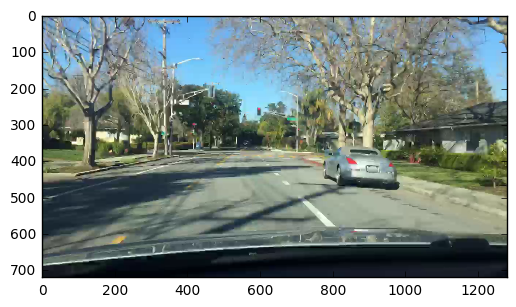

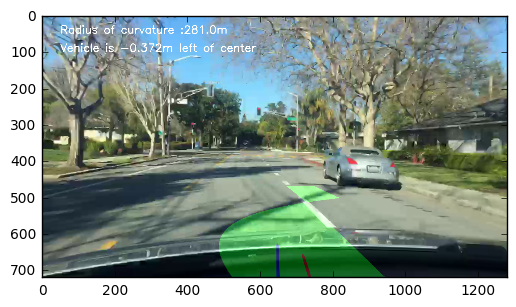

In [27]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
#from IPython.display import HTML
from pipeline import *
import sys
import os
%matplotlib inline
img = np.load('img.npy')
plt.imshow(img)
plt.show()
mod_img = pipeline(img)
plt.imshow(mod_img)
plt.show()